In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

In [56]:
import os
os.chdir("C:\\Users\\faizan\\Documents\\IMLChallenge02")

In [57]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [58]:
# Extract features and target variable from the training data
X = df_train.drop(columns=['price_doc'])  # Features
y = df_train['price_doc']  # Target variable

In [59]:
# Split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Define numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('variance_filter', VarianceThreshold(threshold=0.05))  # Add variance-based filter
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OrdinalEncoder())  # Use OneHotEncoder for dummy encoding
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Add PCA to the model
pca = PCA(n_components=38)

# Add SelectKBest for feature selection
k_best = SelectKBest(score_func=f_regression, k=100)

# Preprocess the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)



In [61]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_valid_tensor = torch.tensor(preprocessor.transform(X_valid), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)

In [68]:
# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# Define the PyTorch neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)
        return x

# Initialize the model
input_size = X_train_preprocessed.shape[1]
model = NeuralNetwork(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Define early stopping parameters
early_stopping = {'patience': 20, 'best_loss': float('inf'), 'counter': 0}

# Convert validation data to PyTorch tensors
X_valid_tensor = torch.tensor(preprocessor.transform(X_valid), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)

In [70]:
# Training loop
num_epochs = 350
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate and update learning rate
    model.eval()
    with torch.no_grad():
        valid_outputs = model(X_valid_tensor)
        valid_loss = criterion(valid_outputs, y_valid_tensor)
        lr_scheduler.step(valid_loss)

        # Early stopping
        if valid_loss < early_stopping['best_loss']:
            early_stopping['best_loss'] = valid_loss
            early_stopping['counter'] = 0
        else:
            early_stopping['counter'] += 1

        if early_stopping['counter'] >= early_stopping['patience']:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {valid_loss.item()}')

Epoch [1/350], Loss: 179349026242560.0
Epoch [2/350], Loss: 177754737737728.0
Epoch [3/350], Loss: 181377492320256.0
Epoch [4/350], Loss: 181668157587456.0
Epoch [5/350], Loss: 180105141813248.0
Epoch [6/350], Loss: 174800186114048.0
Epoch [7/350], Loss: 184580816502784.0
Epoch [8/350], Loss: 172388494868480.0
Epoch [9/350], Loss: 178333534912512.0
Epoch [10/350], Loss: 173777245700096.0
Epoch [11/350], Loss: 172042397679616.0
Epoch [12/350], Loss: 181210559021056.0
Epoch [13/350], Loss: 177028804378624.0
Epoch [14/350], Loss: 172928150798336.0
Epoch [15/350], Loss: 171091280527360.0
Epoch [16/350], Loss: 177094537510912.0
Epoch [17/350], Loss: 177744805625856.0
Epoch [18/350], Loss: 178227469352960.0
Epoch [19/350], Loss: 172929023213568.0
Epoch [20/350], Loss: 173014217916416.0
Epoch [21/350], Loss: 174508816203776.0
Epoch [22/350], Loss: 175169955954688.0
Epoch [23/350], Loss: 173925069750272.0
Epoch [24/350], Loss: 181217639006208.0
Epoch [25/350], Loss: 174798994931712.0
Epoch 000

In [71]:
# Make predictions on the validation set
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_valid_tensor)

# Convert predictions back to numpy array
y_pred = y_pred_tensor.numpy()

# Evaluate the model
mse = mean_squared_error(y_valid, y_pred)
print(f'Mean Squared Error on Validation Set: {mse}')

# Now, make predictions on the test set
X_test_tensor = torch.tensor(preprocessor.transform(df_test), dtype=torch.float32)

model.eval()
with torch.no_grad():
    test_predictions_tensor = model(X_test_tensor)

# Convert predictions back to numpy array
test_predictions = test_predictions_tensor.numpy()

# Save predictions to a CSV file
submission_df = pd.DataFrame({'row ID': range(1, len(test_predictions) + 1), 'price_doc': test_predictions.flatten()})
submission_df.to_csv('prediction_neuralNetwork.csv', index=False)

Mean Squared Error on Validation Set: 174147288378483.25


In [51]:
# Add PCA to the model
pca = PCA(n_components=38)  # Adjust the number of components as needed

# Combine preprocessor, PCA, and the model
full_model = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('regressor', MLPRegressor(hidden_layer_sizes=(128, 64, 32, 16), alpha=0.01, max_iter=350, random_state=42, early_stopping=True, n_iter_no_change=10))
])

In [37]:
# Increase model complexity
model = keras.Sequential([
    layers.Input(shape=(X_train_preprocessed.shape[1],), sparse=True),
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l1(0.05)),
    layers.BatchNormalization(),
    # layers.Dropout(0.2),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.05)),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.05)),
    layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.05)),
    layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.05)),
    layers.Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.05)),
    layers.Dense(1)
])

# Combine preprocessor, PCA, and the model
full_model = Pipeline([
    ('preprocessor', preprocessor),
    # ('feature_selection', k_best),
    ('pca', pca),
    ('regressor', model)
])

# Use Adam optimizer with a different learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.05, decay_steps=1000, decay_rate=0.9)
model.compile(optimizer=keras.optimizers.Nadam(learning_rate=lr_schedule), loss='mean_squared_error')

# Implement early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [52]:
# Train the model with enhancements
history = model.fit(X_train_preprocessed, y_train, epochs=350, batch_size=64,
                    validation_data=(preprocessor.transform(X_valid), y_valid),
                    callbacks=[early_stopping])

Epoch 1/350
2269/2269 [==============================] - 17s 7ms/step - loss: 168226268905472.0000 - val_loss: 169539857809408.0000
Epoch 2/350
2269/2269 [==============================] - 21s 9ms/step - loss: 168994245967872.0000 - val_loss: 169496035721216.0000
Epoch 3/350
2269/2269 [==============================] - 21s 9ms/step - loss: 168301900595200.0000 - val_loss: 169508115316736.0000
Epoch 4/350
2269/2269 [==============================] - 19s 8ms/step - loss: 168373405089792.0000 - val_loss: 169595709161472.0000
Epoch 5/350
2269/2269 [==============================] - 19s 8ms/step - loss: 168575922864128.0000 - val_loss: 169489878482944.0000
Epoch 6/350
2269/2269 [==============================] - 17s 7ms/step - loss: 168507153055744.0000 - val_loss: 169510145359872.0000
Epoch 7/350
2269/2269 [==============================] - 11s 5ms/step - loss: 168180936867840.0000 - val_loss: 169501186326528.0000
Epoch 8/350
2269/2269 [==============================] - 14s 6ms/step - loss

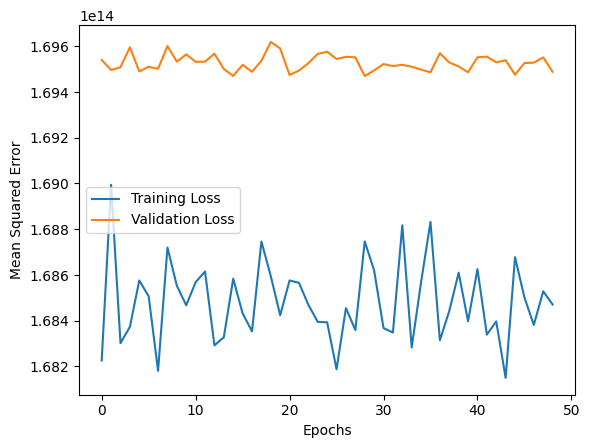

In [53]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [54]:
# Make predictions on the validation set
X_valid_preprocessed = preprocessor.transform(X_valid)
y_pred = model.predict(X_valid_preprocessed)

# Evaluate the model
mse = mean_squared_error(y_valid, y_pred)
print(f'Mean Squared Error on Validation Set: {mse}')

# Now, make predictions on the test set
X_test_preprocessed = preprocessor.transform(df_test)
test_predictions = model.predict(X_test_preprocessed)

1135/1135 [==============================] - 2s 2ms/step
Mean Squared Error on Validation Set: 169469257614273.47
2431/2431 [==============================] - 4s 2ms/step


In [49]:

# Save predictions to a CSV file
submission_df = pd.DataFrame({'row ID': range(1, len(test_predictions) + 1), 'price_doc': test_predictions.flatten()})

# Save the DataFrame to a CSV file
submission_df.to_csv('prediction_neuralNetwork.csv', index=False)

In [50]:
# Print the number of features used after preprocessing
num_features_used = X_train_preprocessed.shape[1]
print(f'Number of Features Used: {num_features_used}')

Number of Features Used: 271
